In [1]:
# from torchsummary import summary
# from torchviz import make_dot
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import tqdm

from model import UNetPlusPlus
from utils import *

In [2]:
lr = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 16
epochs = 1
pin_memory = True

# Data

Path: \
stenosis_train = ARCADE('dataset/stenosis/train')\
stenosis_test = ARCADE('dataset/stenosis/test')\
stenosis_val = ARCADE('dataset/stenosis/val')\
syntax_train = ARCADE('dataset/syntax/train')\
syntax_test = ARCADE('dataset/syntax/test')\
syntax_val = ARCADE('dataset/syntax/val')

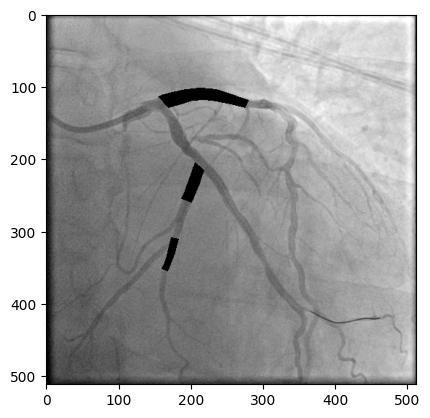

In [3]:
sample = ARCADE('dataset/stenosis/test')[10]
image = sample[0].reshape((512, 512))
mask = sample[1].reshape((512, 512))

plot_image_with_mask(image, mask)

In [4]:
image.shape

(512, 512)

In [5]:
mask.shape

(512, 512)

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float())
])

In [7]:
stenosis_train, stenosis_test, stenosis_val = get_loaders('dataset/stenosis/train', 'dataset/stenosis/test',
                                                          'dataset/stenosis/val', 16, transform, transform, transform)

# syntax_train, syntax_test, syntax_val = get_loaders('dataset/syntax/train', 'dataset/syntax/test', 'dataset/syntax/val', 16)

# Model

In [8]:
# model = UNetPlusPlus()
# summary(model, (1, 512, 512))

In [9]:
# os.environ["PATH"] += os.pathsep + 'F:/Program Files/Graphviz/bin/'
# x = torch.randn(1, 1, 512, 512)
# y = model(x)
# make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True).render("rnn_torchviz", format="png")

# Training

In [10]:
model = UNetPlusPlus().to(device)

In [11]:
unet_features = [32, 64, 128, 256, 512]
wide_unet_features = [35, 70, 140, 280, 560]

In [12]:
def train(data_loader, model, optimizer, criterion , scaler):
    loop = tqdm.tqdm(data_loader, position=1)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = criterion (predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


In [ ]:
criterion  = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
best_accuracy, best_dice_score = accuracy(stenosis_val, model, device=device)
scaler = torch.cuda.amp.GradScaler()
for epoch in tqdm.trange(epochs, position=0):

    train(stenosis_train, model, optimizer, criterion , scaler)

    curr_accuracy, curr_dice_score = accuracy(stenosis_val, model, device=device)

    if curr_accuracy > best_accuracy and curr_dice_score > best_dice_score:
        best_accuracy = curr_accuracy
        best_dice_score = curr_dice_score
        print(f"Best accuracy: {best_accuracy}, Best dice score: {best_dice_score}")

        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

